In [85]:
from os import listdir
from os.path import isfile
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import brewer2mpl
import matplotlib.font_manager
%matplotlib inline
# args ( name, type, number of colors)
pd.set_option('display.mpl_style', 'default')
bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
mpl.rcParams['axes.color_cycle'] = bmap.mpl_colors
mpl.rcParams['font.size'] = 14


In [86]:
# get hdfs log files
hdfs_files = [f for f in listdir() if isfile(f) & f.startswith('hdfs') & f.endswith('.log')]   
print(hdfs_files)

['hdfs-dfs-lsr-20151024.log']


In [87]:
# only read in first log file for now (in the future read in more files to compare different snapshots)
hdfs_files = ['hdfs-dfs-lsr-20151024.log']
df = pd.DataFrame()
for f in hdfs_files:
    dft = pd.read_csv(f, delim_whitespace=True, names=['permissions', 'replicas', 'user', 'group', 'size', 'mod_date', 'mod_time', 'fname'])
    dft['src'] = f.replace('hdfs-dfs-lsr-','').replace('.log','')
    df = pd.concat([df, dft])

df.head()

,permissions,replicas,user,group,size,mod_date,mod_time,fname,src
0,drwxrwxrwx,-,yarn,hadoop,0,2015-10-20,13:26,/app-logs,20151024
1,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa,20151024
2,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-21,00:47,/app-logs/ambari-qa/logs,20151024
3,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024
4,-rw-r-----,2,ambari-qa,hadoop,384,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024


In [88]:
#df = pd.read_csv('hdfs-dfs-lsr-1.log', delim_whitespace=True, names=['permissions', 'replicas', 'user', 'group', 'size', 'mod_date', 'mod_time', 'fname'])



In [89]:
df.head()

,permissions,replicas,user,group,size,mod_date,mod_time,fname,src
0,drwxrwxrwx,-,yarn,hadoop,0,2015-10-20,13:26,/app-logs,20151024
1,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa,20151024
2,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-21,00:47,/app-logs/ambari-qa/logs,20151024
3,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024
4,-rw-r-----,2,ambari-qa,hadoop,384,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024


In [90]:
df['is_dir'] = df['permissions'].apply(lambda x: True if x[0] == 'd' else False)
df['num_replicas'] = pd.to_numeric(df.replicas,'coerce')
df['dt_mod'] = pd.to_datetime(df.mod_date + ' ' + df.mod_time)
df['size_mb'] = df['size'].apply(lambda size: size/1024/1024)
df.head()

,permissions,replicas,user,group,size,mod_date,mod_time,fname,src,is_dir,num_replicas,dt_mod,size_mb
0,drwxrwxrwx,-,yarn,hadoop,0,2015-10-20,13:26,/app-logs,20151024,True,NaN,2015-10-20 13:26:00,0.000000
1,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa,20151024,True,NaN,2015-10-20 13:26:00,0.000000
2,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-21,00:47,/app-logs/ambari-qa/logs,20151024,True,NaN,2015-10-21 00:47:00,0.000000
3,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024,True,NaN,2015-10-20 13:26:00,0.000000
4,-rw-r-----,2,ambari-qa,hadoop,384,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024,False,2,2015-10-20 13:26:00,0.000366


In [91]:
# num files
df[(df.is_dir==False)]['fname'].count()

1708

In [92]:
# num files and directories
# True=Directory; False=File
df.groupby(['is_dir'])['fname'].count()

is_dir
False    1708
True     1029
Name: fname, dtype: int64

In [93]:
#num files/dirs per user:group
df.groupby(['user','group','is_dir'])['fname'].count()

user       group   is_dir
ambari-qa  hadoop  False      91
                   True       39
           hdfs    False      42
                   True       25
anonymous  hdfs    True        1
hbase      hdfs    False     604
                   True      827
hcat       hdfs    True        1
hdfs       hadoop  False      10
           hdfs    False     139
                   True       94
hive       hdfs    True        7
mapred     hadoop  True        9
           hdfs    True        1
oozie      hadoop  True        1
           hdfs    False     822
                   True       22
spark      hdfs    True        1
yarn       hadoop  True        1
Name: fname, dtype: int64

In [94]:
# quota per user:group
df.groupby(['user','group'])['size_mb'].sum()

user       group 
ambari-qa  hadoop      3.866881
           hdfs       20.353203
anonymous  hdfs        0.000000
hbase      hdfs        0.388103
hcat       hdfs        0.000000
hdfs       hadoop    872.678347
           hdfs        8.032172
hive       hdfs        0.000000
mapred     hadoop      0.000000
           hdfs        0.000000
oozie      hadoop      0.000000
           hdfs      602.341820
spark      hdfs        0.000000
yarn       hadoop      0.000000
Name: size_mb, dtype: float64

In [95]:
# last seen (user:group)
df.groupby(['user','group'])['dt_mod'].max()

user       group 
ambari-qa  hadoop   2015-10-21 00:48:00
           hdfs     2015-10-21 11:16:00
anonymous  hdfs     2015-10-20 22:13:00
hbase      hdfs     2015-10-24 05:43:00
hcat       hdfs     2015-10-20 06:30:00
hdfs       hadoop   2015-10-21 00:25:00
           hdfs     2015-10-23 14:32:00
hive       hdfs     2015-10-21 11:16:00
mapred     hadoop   2015-10-21 00:47:00
           hdfs     2015-10-20 06:29:00
oozie      hadoop   2015-10-20 13:27:00
           hdfs     2015-10-21 00:31:00
spark      hdfs     2015-10-20 06:28:00
yarn       hadoop   2015-10-20 13:26:00
Name: dt_mod, dtype: datetime64[ns]

In [96]:
# validate last seen for hdfs user
df[(df.user=='hdfs')]['dt_mod'].sort_values(ascending=False)

1607   2015-10-23 14:32:00
1595   2015-10-23 14:32:00
1605   2015-10-23 14:32:00
1606   2015-10-23 14:32:00
1600   2015-10-22 14:32:00
1604   2015-10-22 14:32:00
1601   2015-10-21 15:30:00
1602   2015-10-21 15:30:00
1603   2015-10-21 15:30:00
1599   2015-10-21 14:32:00
85     2015-10-21 11:06:00
84     2015-10-21 11:06:00
1597   2015-10-21 01:01:00
1608   2015-10-21 00:49:00
1786   2015-10-21 00:44:00
1711   2015-10-21 00:44:00
1710   2015-10-21 00:44:00
1709   2015-10-21 00:44:00
1708   2015-10-21 00:44:00
1707   2015-10-21 00:44:00
1706   2015-10-21 00:44:00
1783   2015-10-21 00:44:00
1784   2015-10-21 00:44:00
1785   2015-10-21 00:44:00
1787   2015-10-21 00:44:00
1788   2015-10-21 00:44:00
1694   2015-10-21 00:44:00
1695   2015-10-21 00:44:00
1797   2015-10-21 00:44:00
1796   2015-10-21 00:44:00
               ...        
1534   2015-10-21 00:25:00
1535   2015-10-21 00:25:00
1537   2015-10-21 00:25:00
1538   2015-10-21 00:25:00
1621   2015-10-21 00:17:00
1880   2015-10-21 00:05:00
1

In [97]:
# average replicas
df['num_replicas'].describe()

count    1708.000000
mean        2.074941
std         0.770885
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        10.000000
Name: num_replicas, dtype: float64

In [98]:
# average replica user:group
df.groupby(['user','group'])['num_replicas'].mean()

user       group 
ambari-qa  hadoop    2.000000
           hdfs      5.047619
anonymous  hdfs           NaN
hbase      hdfs      2.000000
hcat       hdfs           NaN
hdfs       hadoop    2.000000
           hdfs      2.000000
hive       hdfs           NaN
mapred     hadoop         NaN
           hdfs           NaN
oozie      hadoop         NaN
           hdfs      2.000000
spark      hdfs           NaN
yarn       hadoop         NaN
Name: num_replicas, dtype: float64

In [99]:
# permission count by object type
df.groupby(['is_dir','permissions'])['fname'].count()

is_dir  permissions
False   -r--r--r--       10
        -rw-r-----       49
        -rw-r--r--     1462
        -rwx--x---        4
        -rwxr-xr-x      143
        -rwxrwx---       40
True    dr-xr-xr-x        8
        drwx------       22
        drwx--x--x        2
        drwx-wx-wx        1
        drwxr-xr-x      941
        drwxrwx---       47
        drwxrwxr-x        2
        drwxrwxrwt        1
        drwxrwxrwx        5
Name: fname, dtype: int64

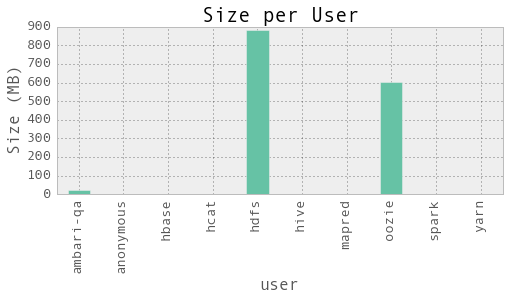

In [100]:
plt_size_user = df['size_mb'].groupby(df['user']).agg(sum)
plt.xlabel('User')
plt.ylabel('Size (MB)')
plt.title('Size per User')
plt_size_user.plot(kind='bar', figsize=(8,3))

In [101]:
df['path_main'] = df.fname.apply(lambda fname: fname[1:fname.find('/', 1)] if fname.find('/', 1) > 0 else fname[1:])
df['path_main'].unique()

array(['app-logs', 'apps', 'hdp', 'mapred', 'mr-history', 'ranger', 'tmp',
       'user'], dtype=object)

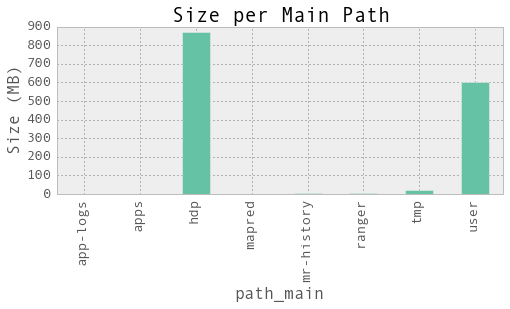

In [102]:
plt.xlabel('Main Path')
plt.ylabel('Size (MB)')
plt.title('Size per Main Path')
df.groupby(['path_main'])['size_mb'].sum().plot(kind='bar', figsize=(8,3))

In [103]:
# calculates something like the user or group based on the prefix of a path
# E.g.: All Projects all located in /projects/ => /projects/proj_a, /projects/proj_b, etc.
# Fname_id = proj_a, proj_b,... => size,# files etc. can be calculated based on this id
df['fname_id'] = ""
search = '/user/'
selection = df['fname'].map(lambda x: x.startswith(search))
df['fname_id'] = df[selection]['fname'].map(lambda x: x[len(search): x.find('/',len(search))+1].replace('/',''))

df.head()

,permissions,replicas,user,group,size,mod_date,mod_time,fname,src,is_dir,num_replicas,dt_mod,size_mb,path_main,fname_id
0,drwxrwxrwx,-,yarn,hadoop,0,2015-10-20,13:26,/app-logs,20151024,True,NaN,2015-10-20 13:26:00,0.000000,app-logs,NaN
1,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa,20151024,True,NaN,2015-10-20 13:26:00,0.000000,app-logs,NaN
2,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-21,00:47,/app-logs/ambari-qa/logs,20151024,True,NaN,2015-10-21 00:47:00,0.000000,app-logs,NaN
3,drwxrwx---,-,ambari-qa,hadoop,0,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024,True,NaN,2015-10-20 13:26:00,0.000000,app-logs,NaN
4,-rw-r-----,2,ambari-qa,hadoop,384,2015-10-20,13:26,/app-logs/ambari-qa/logs/application_144537273...,20151024,False,2,2015-10-20 13:26:00,0.000366,app-logs,NaN


In [104]:
# quota per filename id
df.groupby(['fname_id'])['size_mb'].sum()

fname_id
               0.000000
ambari-qa      0.526881
oozie        602.341820
Name: size_mb, dtype: float64